# PART 2 : IMPROVE THE F1_SCORE

In [141]:
# Loading librairies needed
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import plotly.express as px

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # to avoid deprecation warnings

import joblib


In [142]:
# Loading dataset
dataset = pd.read_csv("src/conversion_data_train.csv")

In [143]:
# Visualize the 5 first rows
dataset.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [144]:
# Checking the shape
dataset.shape

(284580, 6)

STEP 2 : MISSING VALUE MANAGEMENT

In [145]:
dataset.isnull().sum()

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

STEP 3 : GETTING A SAMPLE OF THE DATASET

In [146]:
# Creating a dataset with 10000 observations
data = dataset.sample(10000)

STEP 4 : REPLACING THE NUMBER BY CORRESPONDING NAME CATEGORY

In [147]:
data['new_user'] = data["new_user"].apply(lambda x : "Yes" if x == 1 else "No")

In [148]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
104819,UK,26,No,Ads,2,0
156106,US,37,No,Seo,1,0
40854,US,33,No,Direct,3,0
9740,US,27,Yes,Seo,4,0
103161,China,35,No,Direct,5,0


STEP 5 : PREPROCESSSING

In [149]:
# Getting the list of columns
columns_list = data.columns.to_list()

In [150]:
# Splitting the name of features from the target variable
features_list = columns_list[:-1]
target_variable = "converted"

In [151]:
# Separating features from the target variable
X = data.loc[:, features_list]
y = data.loc[:, target_variable]

In [152]:
# Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []
for i,t in X.dtypes.iteritems():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

Found numeric features  ['age', 'total_pages_visited']
Found categorical features  ['country', 'new_user', 'source']


/var/folders/nx/071z14z97r18yd_vgqdnxk0m0000gn/T/ipykernel_74844/2249989688.py:4: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



In [153]:
# Dividing dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(X ,y, 
                                                    test_size = 0.1, 
                                                    random_state=42)

In [154]:
# Create pipeline for categorical features
categorical_transformer = OneHotEncoder(drop='first') 

In [155]:
# Create pipeline for numeric features
numeric_transformer = StandardScaler() 

In [156]:
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [157]:
# Preprocessings on train set
X_train = preprocessor.fit_transform(X_train)

# Label encoding
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)

# Preprocessings on test set
X_test = preprocessor.transform(X_test) 

# Label encoding
y_test = encoder.transform(y_test)


STEP 6 : TRAINING MODEL : DECISION TREE - WITH DATA_TRAIN.CSV

In [158]:
classifier = DecisionTreeClassifier()

# Grid of values to be tested
params = {
    'max_depth': [4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 4, 8]
}
gridsearch = GridSearchCV(classifier, param_grid = params, cv = 10)# cv : the number of folds to be used for CV
gridsearch.fit(X_train, y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

...Done.
Best hyperparameters :  {'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 4}
Best validation accuracy :  0.9816666666666668


In [159]:
# Predictions on training set
y_train_pred = gridsearch.predict(X_train)

# It's also possible to get the probabilities estimated by the model:
y_train_proba = gridsearch.predict_proba(X_train)

In [160]:
# Predictions on test set
y_test_pred = gridsearch.predict(X_test)

# It's also possible to get the probabilities estimated by the model:
y_test_proba = gridsearch.predict_proba(X_test)


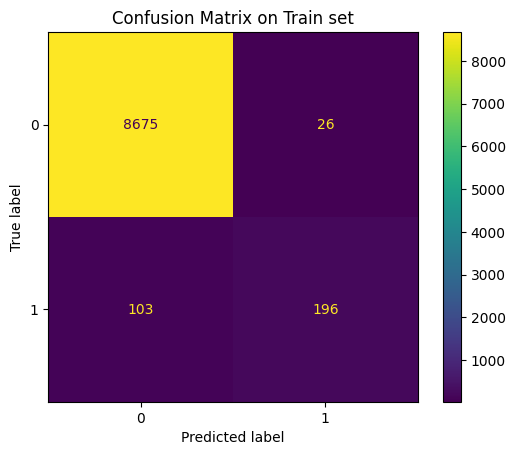

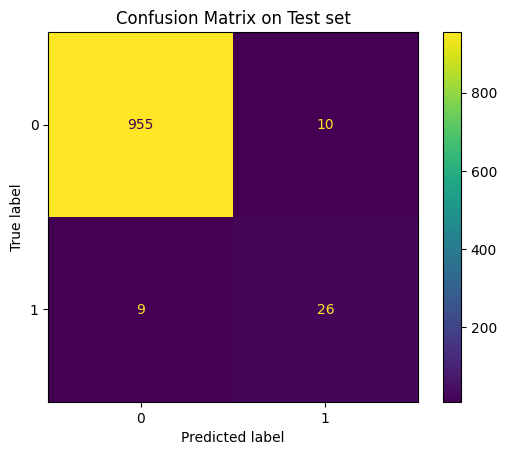

In [161]:
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearch, X_train, y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearch, X_test, y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

In [162]:
# Printing score F1_score
print("f1-score on training set : ", f1_score(y_train, y_train_pred))
print("f1-score on test set : ", f1_score(y_test, y_test_pred))

f1-score on training set :  0.7523992322456815
f1-score on test set :  0.732394366197183


STEP 7 : SAVE MODEL

In [163]:
joblib.dump(gridsearch.best_estimator_, "src/model.joblib", compress=3)

['src/model.joblib']

STEP 8 : RANDOM FOREST APPLICATION

In [172]:
# Perform grid search
classifier = RandomForestClassifier()

# Grid of values to be tested
params = {
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 4, 8],
    'n_estimators': [10, 20, 40, 60, 80, 100]
}
gridsearch = GridSearchCV(classifier, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, y_train)
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Best hyperparameters :  {'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 80}
Best validation accuracy :  0.9841111111111109


In [165]:
# Predictions on training set
y_train_pred = gridsearch.predict(X_train)

# It's also possible to get the probabilities estimated by the model:
y_train_proba = gridsearch.predict_proba(X_train)

In [166]:
# Predictions on test set
y_test_pred = gridsearch.predict(X_test)

# It's also possible to get the probabilities estimated by the model:
y_test_proba = gridsearch.predict_proba(X_test)


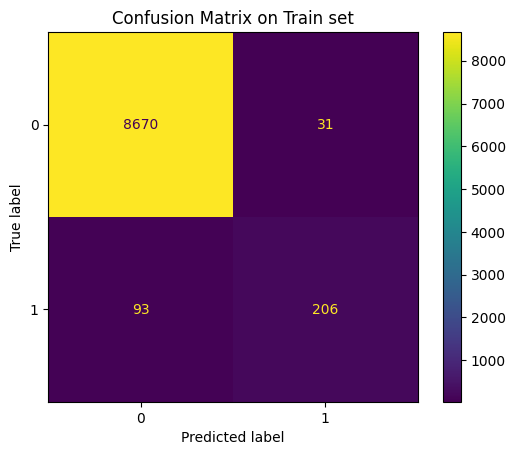

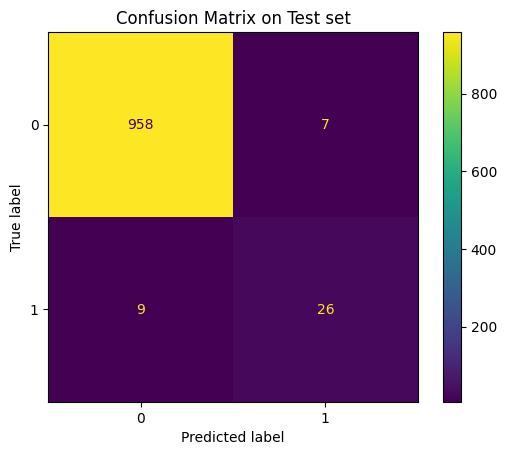

In [167]:
# Visualize confusion matrices
_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Train set") 
ConfusionMatrixDisplay.from_estimator(gridsearch, X_train, y_train, ax=ax) 
plt.show()

_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Test set")
ConfusionMatrixDisplay.from_estimator(gridsearch, X_test, y_test, ax=ax) 
plt.show()

In [168]:
print("f1-score on training set : ", f1_score(y_train, y_train_pred))
print("f1-score on test set : ", f1_score(y_test, y_test_pred))


f1-score on training set :  0.7686567164179106
f1-score on test set :  0.7647058823529412


STEP 9 : FEATURE IMPORTANCE APPLICATION

In [169]:
column_names = []
for name, step, features_list in preprocessor.transformers_: # loop over steps of ColumnTransformer
    if name == 'num': # if pipeline is for numeric variables
        features = features_list # just get the names of columns to which it has been applied
    else: # if pipeline is for categorical variables
        features = step.get_feature_names_out() # get output columns names from OneHotEncoder
    column_names.extend(features) # concatenate features names
        
print("Names of columns corresponding to each coefficient: ", column_names)

Names of columns corresponding to each coefficient:  ['age', 'total_pages_visited', 'country_Germany', 'country_UK', 'country_US', 'new_user_Yes', 'source_Direct', 'source_Seo']


In [170]:
# Create a pandas DataFrame
feature_importance = pd.DataFrame(index = column_names, data = gridsearch.best_estimator_.feature_importances_, columns=["feature_importances"])
feature_importance = feature_importance.sort_values(by = 'feature_importances')

In [171]:
# Plot coefficients
fig = px.bar(feature_importance, orientation = 'h')
fig.update_layout(showlegend = False, 
                  margin = {'l': 120}, # to avoid cropping of column names
                 autosize=True, 
                    width=600,
                    height=500,
                    title = "Features importance")
                    
fig.show()

# END PART 2